# Homework 4: Can you predict the Midterm Elections?

---

## Introduction

**Add Introduction**

You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a final prediction of the result of each state.

#### Data

We will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

In [18]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO, BytesIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
import collections

In [19]:
# special matplotlib argument for improved plots
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Problem 1: Data Wrangling

We will read in the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) and create a dictionary of DataFrames as well a master table information for each race.

#### Problem 1(a)

Read in [this JSON object](http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate) containing the polls for the 2014 Senate Elections using the HuffPost API. Call this JSON object `info`.  This JSON object is imported as a list in Python where each element contains the information for one race.  Use the function `type` to confirm the that `info` is a list. 

In [20]:
# your code here
url_str = "http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate"
info = requests.get(url_str).json()
type(info)

list

#### Problem 1(b)

For each element of the list in `info` extract the state. We should have one poll per state, but we do not. Why?

**Hint**: Use the internet to find out information on the races in each state that has more than one entry. Eliminate entries of the list that represent races that are not happening.

首先，用列表推导从`state`抽取出每个种族。然后，用`collections.Counter`来判断哪些州有多个种族。

In [22]:
states = [str(election['state']) for election in info]
titles = [str(election['title']) for election in info]

countStates = collections.Counter(states)
print(countStates)

Counter({'SC': 2, 'OK': 2, 'NH': 2, 'AK': 1, 'WV': 1, 'MA': 1, 'NJ': 1, 'GA': 1, 'RI': 1, 'AR': 1, 'TN': 1, 'HI': 1, 'MT': 1, 'IA': 1, 'DE': 1, 'MS': 1, 'CO': 1, 'MN': 1, 'IL': 1, 'VA': 1, 'ID': 1, 'NM': 1, 'TX': 1, 'LA': 1, 'KY': 1, 'WY': 1, 'NE': 1, 'NC': 1, 'MI': 1, 'OR': 1, 'KS': 1, 'ME': 1, 'SD': 1})


In [23]:
twoPollIndex = [elem[0] for elem in countStates.most_common(4)]
twoPollIndex

['SC', 'OK', 'NH', 'AK']

我们可以打印每个州的所有竞选多于一场的比赛，并使用谷歌来了解更多关于每场比赛的信息。

In [24]:
for state in twoPollIndex:
    ind = [i for i, x in enumerate(states) if x == state]
    for elem in ind:
        print('title: %s (index: %g)' % (titles[elem], elem))

title: 2014 South Carolina Senate: Scott vs. Dickerson (index: 13)
title: 2014 South Carolina Senate: Graham vs. Hutto (index: 14)
title: 2014 Oklahoma Senate: Lankford vs. Johnson (index: 4)
title: 2014 Oklahoma Senate: Inhofe vs. Silverstein (index: 12)
title: 2014 New Hampshire Senate: Bass vs. Shaheen (index: 29)
title: 2014 New Hampshire Senate: Brown vs. Shaheen (index: 31)
title: 2014 Alaska Senate: Sullivan vs. Begich (index: 24)


Using some [google-fu](http://www.urbandictionary.com/define.php?term=google-fu), we see the races in Oklahoma and South Carolina are special elections. In Georgia, we should remove the senate runoff races and in New Hampshire, we see Bass withdrew so we will take out both of these races from our `info` JSON object.  The indices in the `info` list is 6 and 36. Therefore, we will remove these indices. 

In [25]:
removeset = set([6, 36])
infoClean = [v for i, v in enumerate(info) if i not in removeset]

#### Problem 1(c)

Create a dictionary of pandas DataFrames called `polls` keyed by the name of the election (a string). Each value in the dictionary should contain the polls for one of the races.

In [26]:
# your code here
election_urls = [election['url'] + '.csv' for election in infoClean]

To create a dictionary of pandas DataFrames that will be keyed by the name of the election (a string), we use the following function `build_frame` introduced in [Homework 2](http://nbviewer.ipython.org/github/cs109/2014/blob/master/homework/HW2.ipynb). 

In [29]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    s = StringIO(source)
    
    return pd.DataFrame.from_csv(s, index_col=None).convert_objects(convert_dates='coerce', convert_numeric=True)

In [30]:
# Make a dictionary of pandas DataFrames keyed on election string.
polls = dict((election['slug'], build_frame(election['url']+'.csv')) for election in infoClean)

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


The `dfs` dictionary contains a set of key-value pairs where the `key` is string of the election and the value is a pandas DataFrame with the polls for one 2014 Senate race. We can print the first few keys of the `dfs` dictionary using `keys()`. 

In [36]:
polls.keys()

dict_keys(['2014-delaware-senate-wade-vs-coons', '2014-minnesota-senate-mcfadden-vs-franken', '2014-wyoming-senate', '2014-virginia-senate-gillespie-vs-warner', '2014-south-carolina-senate-scott-vs-dickerson', '2014-colorado-senate-gardner-vs-udall', '2014-new-mexico-senate-weh-vs-udall', '2014-new-jersey-senate-bell-vs-booker', '2014-massachusetts-senate-herr-vs-markey', '2014-mississippi-senate-cochran-vs-childers', '2014-hawaii-senate-cavasso-vs-schatz', '2014-kentucky-senate-mcconnell-vs-grimes', '2014-oklahoma-senate-lankford-vs-johnson', '2014-rhode-island-senate-zaccaria-vs-reed', '2014-georgia-senate-perdue-vs-nunn', '2014-iowa-senate-ernst-vs-braley', '2014-new-hampshire-senate-brown-vs-shaheen', '2014-tennessee-senate-alexander-vs-ball', '2014-alaska-senate-sullivan-vs-begich', '2014-maine-senate-collins-vs-bellows', '2014-texas-senate-cornyn-vs-alameel', '2014-idaho-senate-risch-vs-mitchell', '2014-michigan-senate-land-vs-peters', '2014-west-virginia-senate-capito-vs-tennant

#### Problem 1(d)

Now create a master table information containing information about each race. Create a pandas DataFrame called `candidates` with rows containing information about each race. The `candidates` DataFrame should have the following columns: 

1. `State` = the state where the race is being held
2. `R` = name of republican candidate
3. `D` = name of non-republican candidate (Democrate or Independent) 
4. `incumbent` = R, D or NA

**Hint**: You will need a considerable amount of data wrangling for this.

In [40]:
%qtconsole

In [44]:
### Your code here ###
rows = []

for i,dt in enumerate(infoClean):
    x = dt['estimates'][0:2]
    if x == []: continue
    if not x[0]['last_name']:
        tmp = dt['url'].split('-')+['vs']
        j = tmp.index('vs')
        if j!=len(tmp)-1:
            R = tmp[j-1].capitalize()
            D = tmp[j+1].capitalize()
            incumbent = np.nan
            #if no data means race is decided
    else:
        tmp = [x[0]['party'],x[1]['party']]
        R = x[tmp.index('Rep')]['last_name']
        idx = [k for k in range(len(tmp)) if tmp[k]!='Rep'][0]
        D = x[idx]['last_name']
        tmp2 = [x[0]['incumbent'],x[1]['incumbent']]
        tmp2+=[True]
        incumbent = np.nan
        if tmp2.index(True)!=2:
            incumbent = tmp[tmp2.index(True)]
            
    rows.append((dt['state'], R, D, incumbent))
    
candidates = pd.DataFrame(rows, columns=["State", "R", "D", "incumbent"])
        
#remove second last name 
candidates.R = [candidate.split(' ')[-1] for candidate in candidates.R]
candidates

,State,R,D,incumbent
0,DE,Wade,Coons,Dem
1,MA,Herr,Markey,Dem
2,MT,Daines,Curtis,NaN
3,OK,Lankford,Johnson,NaN
4,HI,Cavasso,Schatz,Dem
5,WY,Enzi,Hardy,Rep
6,TN,Alexander,Ball,Rep
7,ID,Risch,Mitchell,Rep
8,NJ,Bell,Booker,Dem
9,NM,Weh,Udall,Dem


## Problem 2: Confidence Intervals

Compute a 99% confidence interval for each state. 

#### Problem 2(a)

Assume you have $M$ polls with sample sizes $n_1, \dots, n_M$. If the polls are independent, what is the average of the variances of each poll if the true proportion is $p$?

答案：The variance of a single poll with sample $n_i$ is $Var(X_i) = \frac{p(1-p)}{n_i}$. Therefore, the average of the variances across $M$ polls is

$$ \frac{1}{M} \sum_{i=1}^M Var( {X}_i) = \frac{1}{M} p(1-p)(1/n_1 + \dots +1/n_M) $$

#### Problem 2(b)

Compute the square root of these values in Problem 2(a) for the republican candidates in each race. Then, compute the standard deviations of the observed poll results for each race. 

In [53]:
import datetime, pdb

def calc_sds(infoClean, polls, numdays=None):
    theo_sds = []
    obs_sds = []
    npolls = []
    for ii,election in enumerate(infoClean):
        #Note that the `polls` dictionary does not have a guaranteed ordering
        #because Python dictionaries are unordered object. For this reason, we
        #need to be careful and use the ordered `infoClean` object to make sure we
        #are correctly aligning the elements of `polls` and the rows in `candidates`.
        polls_key = election['slug']
        this_election = polls[polls_key]
        
        #Optional argument to filter on age of polls.
        if numdays is not None:
            monthdiff = this_election['End Date'].apply(lambda x: (datetime.datetime.now()-x).days)
            this_election = this_election.ix[monthdiff <= numdays,:]
            
        npoll = this_election.shape[0]

        #Use the candidates dataframe to find the name of the Republican in this race.
        #Use this to grab the column of polling results for this candidate.
        #Put poll results onto the proportion (not percentage) scale
#         pdb.set_trace()
        if ii >= candidates.shape[0] or candidates.R.ix[ii] not in this_election.columns:
            continue
        else:
            p = this_election[candidates.R.ix[ii]]/100
        n = this_election["Number of Observations"]

        #Theoretical sd assumes a common value of p across all polls. Use the mean.
        p_mean = np.mean(p)
        theo_sd = np.sqrt(p_mean*(1-p_mean)*np.mean(1./n))

        #Observed sd is a simple calculation.
        obs_sd = np.std(p)

        theo_sds.append(theo_sd)
        obs_sds.append(obs_sd)
        npolls.append(npoll)
        
    return (theo_sds, obs_sds, npolls)

theo, obs, npolls = calc_sds(infoClean, polls)

#### Problem 2(c) 

Plot observed versus theoretical (average of the theoretical SDs) with the area of the point proportional to number of polls. How do these compare?

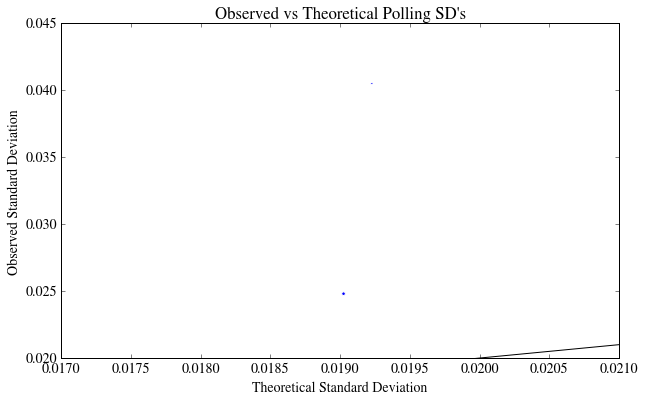

In [54]:
# your code here
#Grab the poll count from the infoClean object.
plt.scatter(theo, obs, marker="o", s=npolls*10)
plt.xlabel("Theoretical Standard Deviation")
plt.ylabel("Observed Standard Deviation")
plt.title("Observed vs Theoretical Polling SD's")

currentx = plt.xlim()
currenty = plt.ylim()
plt.plot((0,1),(0,1), c='black', linewidth=1)
plt.xlim(currentx)
plt.ylim(currenty)
plt.show()

#### Problem 2(d)

Repeat Problem 2(c) but include only the most recent polls from the last two months. Do they match better or worse or the same? Can we just trust the theoretical values?

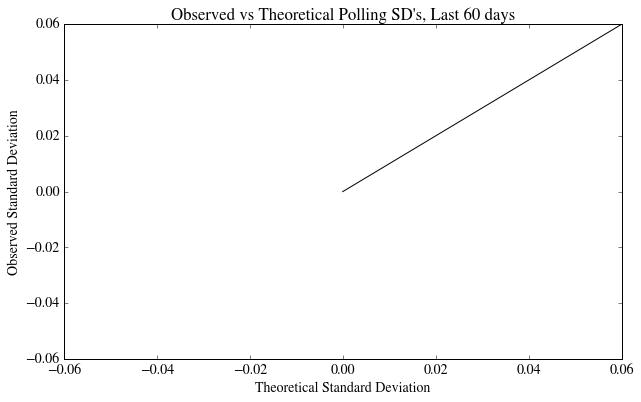

In [57]:
# your code here
# Use the `calc_sds` optional argument to filter on number of days.
# Filter to 60 days.

theo, obs, npolls = calc_sds(infoClean, polls, 60)
plt.scatter(theo, obs, marker="o", s=npolls*10)
plt.xlabel("Theoretical Standard Deviation")
plt.ylabel("Observed Standard Deviation")
plt.title("Observed vs Theoretical Polling SD's, Last 60 days")

currentx = plt.xlim()
currenty = plt.ylim()
plt.plot((0,1),(0,1), c='black', linewidth=1)
plt.xlim(currentx)
plt.ylim(currenty)
plt.show()

回答：在我们关注的最近的民意调查中，理论和观察之间的差距似乎并没有减少。这表明数据相对于理论模型的过度变化量并不是随着时间的推移而被解释。更可能的是，这是由于时间不变的调查机构之间的差异。

#### Problem 2(e)

Create a scatter plot with each point representing one state. Is there one or more races that are outlier in that it they have much larger variabilities than expected ? Explore the original poll data and explain why the discrepancy?

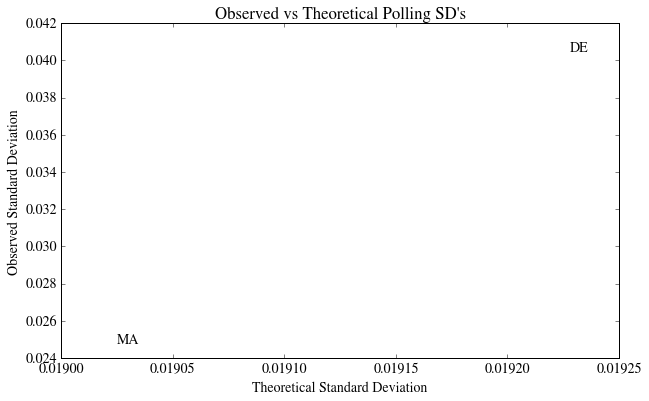

In [58]:
# your code here
#Compute the standard deviations on the full data again.
theo, obs, npolls = calc_sds(infoClean, polls)

#This time, do the scatterplot using text labels on each datapoint.
plt.scatter(theo, obs, marker="o", s=0)
plt.xlabel("Theoretical Standard Deviation")
plt.ylabel("Observed Standard Deviation")
plt.title("Observed vs Theoretical Polling SD's")

for i in range(len(theo)):
    plt.text(theo[i], obs[i], candidates.ix[i,'State'])

currentx = plt.xlim()
currenty = plt.ylim()
plt.plot((0,1),(0,1), c='black', linewidth=1)
plt.xlim(currentx)
plt.ylim(currenty)
plt.show()

回答：Texas appears to be the biggest outlier.

#### Problem 2(f)

Construct confidence intervals for the difference in each race. Use either theoretical or data driven estimates of the standard error depending on your answer to this question. Use the results in Problem 2(e), to justify your choice.

In [60]:
# your code here
# this is mean +- 2.58 SD also save this results to candidate df
def calc_diffs(infoClean, polls, numdays=None):
    rows = []
    for ii,election in enumerate(infoClean):
        #Note that the `polls` dictionary does not have a guaranteed ordering
        #because Python dictionaries are unordered object. For this reason, we
        #need to be careful and use the ordered `infoClean` object to make sure we
        #are correctly aligning the elements of `polls` and the rows in `candidates`.
        polls_key = election['slug']
        this_election = polls[polls_key]
            
        npoll = this_election.shape[0]

        #Use the candidates dataframe to find the name of the Republican in this race.
        #Use this to grab the column of polling results for this candidate.
        #Put poll results onto the proportion (not percentage) scale
        diffs = (this_election[candidates.R.ix[ii]]-this_election[candidates.D.ix[ii]])/100
        
        mean_diff = np.mean(diffs)
        obs_se = np.std(diffs)/np.sqrt(npoll)
        
        rows.append((polls_key, mean_diff, obs_se, mean_diff-obs_se*2.58, mean_diff+obs_se*2.58))

    return rows

ests = pd.DataFrame(calc_diffs(infoClean, polls), columns=['race', 'mean', 'se', 'lower', 'upper'])
print("Unsorted:")
print(ests[['race', 'lower', 'upper']])
ests.sort("mean", inplace=True)
print("Sorted:")
print(ests[['race', 'lower', 'upper']])

plt.errorbar(range(ests.shape[0]), ests['mean'], yerr=ests['se']*2.58, fmt='o')
plt.xticks(range(ests.shape[0]), ests['race'].values, rotation=90)
plt.xlim(-1, ests.shape[0])
plt.axhline(0, linewidth=1, color='black')
plt.xlabel("Race")
plt.ylabel("Difference")
plt.title("99% Confidence intervals for Diff (Rep-Dem) for each race")
plt.show()

KeyError: 'Daines'

# Problem 3: Prediction and Posterior Probabilities

Perform a Bayesian analysis to predict the probability of Republicans winning in each state then provide a posterior distribution of the number of republicans in the senate.

#### Problem 3(a)

First, we define a Bayesian model for each race. The prior for the difference $\theta$ between republicans and democtrats will be $N(\mu,\tau^2)$. Say before seeing poll data you have no idea who is going to win, what should $\mu$ be? How about $\tau$, should it be large or small? 

回答：因为我们没有谁会赢的先验知识，所以先验的均值$\mu$该是0，而且我们也不了解数据，但是我们知道差异不会太大。所以$\tau$应该很小。

#### Problem 3(b)

What is the distribution of $d$ conditioned on $\theta$. What is the posterior distribution of $\theta | d$? 

**Hint**: Use normal approximation. 

回答：$d \mid \theta \sim N(\theta, \sigma^2/M)$. We assume that $\sigma^2$ is known based on the observed sample variance, and $M$ is the number of polls averaged together to obtain $d$.

$\theta \mid d \sim N\left(B\mu + (1-B)d, (1-B)\sigma^2/M\right)$, where $B = \frac{1/\tau^2}{M/\sigma^2 + 1/\tau^2}$. (Note that there are lots of equivalent ways to write $B$, but this one shows that it is a *precision weight*, based on the ratio of the prior precision to the total precision of the prior and the data. Precision here is the inverse of the variance).

Equivalently, $\theta | d$ is $\theta | d \sim N( B \mu + (1-B) d, 1/(M/\sigma^2 + 1/ \tau^2))$.

#### Problem 3(c)

The prior represents what we think before hand. We do not know who is expected to win, so we assume $\mu=0$. For this problem estimate $\tau$ using the observed differences across states (Hint: $\tau$ represents the standard deviation of a typical difference). Compute the posterior mean for each state and plot it against original average. Is there much change? Why or why not? 

In [62]:
# your code here
# A cheap but slightly biased way to estimate tau is to take the
# standard deviation of the state polling means.
# Use `ests` from last question.
tau = np.std(ests['mean'])
B = (1/tau**2)/(1/ests['se']**2+1/tau**2)
ests['mu_post'] = (1-B)*ests['mean']

plt.scatter(ests['mean'], ests['mu_post'], s=50)
plt.title("Bayes vs. Raw Poll Averages")
plt.xlabel("Raw Average")
plt.ylabel("Bayes")

currentx = plt.xlim()
currenty = plt.ylim()
plt.plot((-1,1),(-1,1), c='black', linewidth=1)
plt.xlim(currentx)
plt.ylim(currenty)
plt.show()

NameError: name 'ests' is not defined

**Your answer here:**

Because there are a lot of datapoints (i.e. a lot of polls), $\sigma^2/M$ is much smaller than $\tau^2$, which results in a very small shrinkage factor for each datapoint (most elements of $B$ are extremely small). When you have this much data, the data largely overwhelms the prior. We do see that in those cases where the estimates are moved by the prior, they are pulled closer to zero than their raw average, resulting in a slope slightly shallower than 1.

#### Problem 3(d)

For each state, report a probabilty of Republicans winning. How does your answer here compare to the other aggregators?

In [63]:
# your code here
#First, compute a standard deviation for each poll
ests['sd_post'] = np.sqrt((1-B)*ests['se']**2)

#Now, use normal CDF to find the posterior probability that the difference is greater than zero.
import scipy.stats
ests['R_win_prob'] = 1-scipy.stats.norm.cdf(0, loc=ests['mu_post'], scale=ests['sd_post'])
print(ests[['race','R_win_prob']].sort('R_win_prob'))

SyntaxError: invalid syntax (<ipython-input-63-d86fce2a26ab>, line 8)

**Your answer here:**

As expected from other aggregators, only a few states have outcomes that seem uncertain. Our model seems to be more certain about these tossup races than most aggregators. For us, the states that are less than 99% leaning one way or the other are IA, AK, CO, KS, LA, AR. Other aggregators also include NH, GA, and KY as being closer to tossups. Our model here does not seem to incorporate enough uncertainty (for example, the possibility that all of the polls in a given state might be clustered around the wrong value, as happened in NV in 2010).

#### Problem 3(e)

Use the posterior distributions in a Monte Carlo simulation to generate election results. In each simulation compute the total number of seats the Republican control. Show a histogram of these results.

In [12]:
# your code here
### made up numbers
num_states = ests.shape[0]

NSIM = 10000
simarr = np.zeros(NSIM, dtype=int)
for i in xrange(NSIM):
    simulated = 30 + np.sum(np.random.normal(ests['mu_post'], scale=ests['sd_post'], size =num_states) > 0 )
    simarr[i] = int(simulated)
plt.hist(simarr, bins=range(min(simarr)-1, max(simarr)+3))
plt.xlabel('Number of Seats in Republican Control')
plt.ylabel('Frequency')
plt.title('Monte Carlo simulation of Number of Seats in Republican Control')
plt.show()

## Problem 4

Predict the results for the 2014 Midterm Elections. We will have a three competitions with the terms for scoring entries described above. For both questions below, **explain** or provide commentary on how you arrived at your predictions including code. 

**Hint**: Use election results from 2010, 2012 to build and test models.

#### Problem 4(a)

Predict the number of Republican senators. You may provide an interval. Smallest interval that includes the election day result wins. 

**Note**: we want the total so add the numbers of those that are not up for election.

In [13]:
# your code here

提供方法学上的解释：

#### Problem 4(b)

Predict the R-D difference in each state. The predictions that minimize the residual sum of squares between predicted and observed differences wins.

In [14]:
# your code here

提供方法学上的解释：

#### Problem 4(c)

Report a confidence interval for the R-D difference in each state. If the election day result falls outside your confidence interval in more than two states you are eliminated. For those surviving this cutoff, we will add up the size of all confidence intervals and sum. The smallest total length of confidence interval wins. 

**Note**: you can use Bayesian credible intervals or whatever else you want. 

In [15]:
# your code here

提供方法学上的解释：